<a href="https://colab.research.google.com/github/samlucas28/Thesis-python-scripts/blob/main/Markov_model_BA_OWSA_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



MARKOV RESULTS:
Detected cancers before age 50: 0
Total cost: £19,621.45

--- OWSA on Sensitivity ---
 sensitivity  total_cost  cancers_detected
        0.68    19621.74                 0
        0.73    19621.64                 0
        0.78    19621.45                 0
        0.83    19621.19                 0
        0.88    19620.87                 0

--- OWSA on Specificity ---
 specificity  total_cost  cancers_detected
       0.850    20898.80                 0
       0.875    20260.12                 0
       0.900    19621.45                 0
       0.925    18982.77                 0
       0.950    18344.10                 0

--- OWSA on Uptake ---
 uptake  total_cost  cancers_detected
  0.650    19493.02                 0
  0.725    19555.36                 0
  0.800    19606.84                 0
  0.875    19649.98                 0
  0.950    19686.64                 0

--- OWSA on Screening Detection Cost ---
 detection_cost  total_cost  cancers_detected
          60

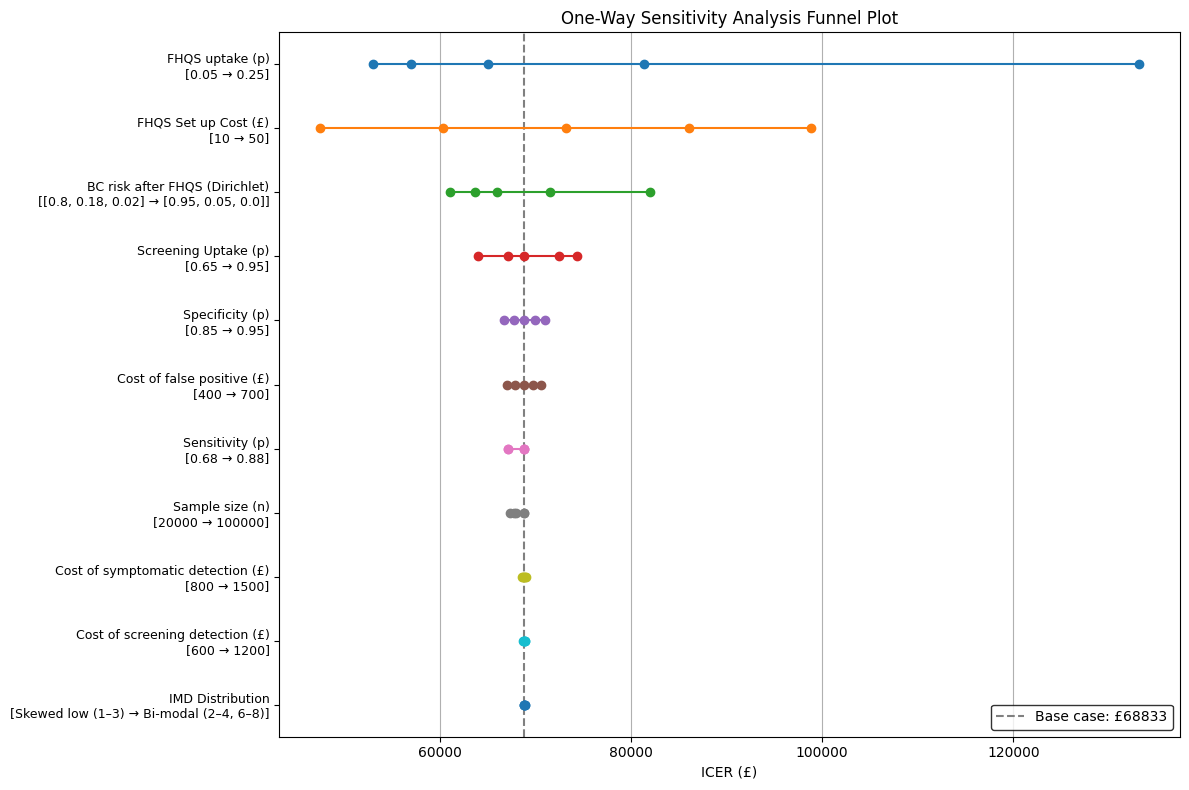

In [ ]:
# -------------------------------------------------------------------
# MARKOV MODEL FOR BASE-CASES/ONE-WAY SENSITIVITY ANALYSES/SCENARIO ANALYSES
# -------------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import beta

# 1. PARAMETERS
# -----------------------
STATES = ["Healthy_TN", "Healthy_FP", "Cancer_Undetected", "Cancer_Detected"] # Definining transition states
ALL_STATES = STATES + ["Exited"]

RISK_GROUPS = ["high_risk", "moderate_risk"] # Defining risk levels
AGE_RANGE = range(38, 50) # Defining age range
CONF_LEVEL = 0.95

# Sensitivity and Specificity
SENS_MEAN, SENS_L, SENS_U = 0.780, 0.730, 0.830 # Sensitivity bounds
SPEC_MEAN, SPEC_L, SPEC_U = 0.90, 0.897, 0.903 # Specificity bounds
# Annual screening uptake
UP_MEAN, UP_L, UP_U = 0.824, 0.754, 0.894 # Screening uptake bounds

# 2. COST PARAMETERS
# ---------------------------------------------------------------
cost_params = { # Defining cost parameters (with gamma distributions)
    "Healthy_TN": 196.40,
    "Healthy_FP_alpha": 207.78,
    "Healthy_FP_beta": 0.376,
    "Cancer_Undetected": 196.40,
    "Cancer_Detected_alpha": 536,
    "Cancer_Detected_beta": 0.604
}

fixed_cost_sample = { # Defining fixed costs
    "Healthy_TN": 196.40,
    "Healthy_FP": 552.66,
    "Cancer_Undetected": 196.40,
    "Cancer_Detected": 887.66
}

# 3. BETA FITTING
# ---------------------------------------------------------------
def beta_from_ci(mean, low, high, conf=CONF_LEVEL):
    z  = abs(beta.ppf([(1-conf)/2, 1-(1-conf)/2], 1, 1) - 0.5)[0]
    sd = (high - low) / (2*z)
    var = sd**2
    tmp = mean * (1-mean) / var - 1
    return mean * tmp, (1-mean) * tmp

α_sens, β_sens = beta_from_ci(SENS_MEAN, SENS_L, SENS_U) # Assigning beta distribtion to sensitivity
α_spec, β_spec = beta_from_ci(SPEC_MEAN, SPEC_L, SPEC_U) # Assigning beta distribtion to specificity
α_up,   β_up   = beta_from_ci(UP_MEAN, UP_L, UP_U) # Assigning beta distribtion to screening uptake


# 4. LOAD PREVALENCE DATA
# -----------------------
prevalence_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Markov prevelance table.xlsx")
prevalence_df.columns = prevalence_df.columns.str.strip()  # Strip spaces from column names

# 5. HELPER FUNCTIONS
# -----------------------
def band_for_age(age):
    return "38-39" if age < 40 else ("40-44" if age < 45 else "45-49") # Converts numeric ages into age bands

def make_matrix(prev, sens, spec, uptake):  # Defining transition matrix
    tn = (1 - prev) * spec # Calculations for TN, FP, FN, TP
    fp = (1 - prev) * (1 - spec)
    fn = prev * (1 - sens)
    tp = prev * sens

    p = {"TN": tn, "FP": fp, "FN": fn, "TP": tp, "sens": sens} # Stores probabilties in dictionary

    M = pd.DataFrame(0., index=ALL_STATES, columns=ALL_STATES) # Initializes a square dataframe with rows to fill
    M.loc["Healthy_TN", "Healthy_TN"] = (1 - uptake) + uptake * p["TN"] # Transition probability calculations with probability of attending screening
    M.loc["Healthy_TN", "Healthy_FP"] = uptake * p["FP"]
    M.loc["Healthy_TN", "Cancer_Undetected"] = uptake * p["FN"]
    M.loc["Healthy_TN", "Cancer_Detected"] = uptake * p["TP"]

    M.loc["Healthy_FP", "Healthy_FP"] = (1 - uptake) + uptake * p["FP"]
    M.loc["Healthy_FP", "Healthy_TN"] = uptake * p["TN"]
    M.loc["Healthy_FP", "Cancer_Undetected"] = uptake * p["FN"]
    M.loc["Healthy_FP", "Cancer_Detected"] = uptake * p["TP"]

    M.loc["Cancer_Undetected", "Cancer_Undetected"] = (1 - uptake) + uptake * (1 - p["sens"])
    M.loc["Cancer_Undetected", "Cancer_Detected"] = uptake * p["sens"]

    M.loc["Cancer_Detected", "Exited"] = 1.0
    M.loc["Exited", "Exited"] = 1.0
    return M

def build_matrices(prevalence_df, uptake): # Building matrices for the full cohort
    matrices = {}
    for _, row in prevalence_df.iterrows(): # Loops over the prevelance dataframe to build transition matrices
        risk = row["risk"]
        age_band = row["age_band"]
        prev = float(row["prevelance"])
        key = (risk, age_band)
        if key not in matrices:
            matrices[key] = make_matrix(prev, SENS_MEAN, SPEC_MEAN, uptake)
    return matrices

def cancers_detected_before_50(matrices, grouped_df): # Function to count the cancer detected before age 50
    total = 0
    for _, row in grouped_df.iterrows(): # loops through risk and start age
        risk, start_age, n = row["risk"], int(row["start_age"]), int(row["n"])
        dist = pd.Series(0., index=ALL_STATES)
        dist["Healthy_TN"] = n
        for age in range(start_age, 50):
            age_band = band_for_age(age)
            dist = dist @ matrices[(risk, age_band)]
        total += dist["Exited"]
    return int(total)

def calculate_costs(matrices, grouped_df, cost_sample, discount_rate=0.035): # Function to calculate the total costs
    total_cost = 0
    for _, row in grouped_df.iterrows():
        risk, start_age, n = row["risk"], row["start_age"], row["n"]
        dist = pd.Series(0., index=ALL_STATES)
        dist["Healthy_TN"] = n
        cohort_cost = 0
        for i, age in enumerate(range(start_age, 50)):
            age_band = band_for_age(age)
            M = matrices[(risk, age_band)]
            year_cost = (
                dist["Healthy_TN"] * cost_sample["Healthy_TN"] +
                dist["Healthy_FP"] * cost_sample["Healthy_FP"] +
                dist["Cancer_Undetected"] * cost_sample["Cancer_Undetected"] +
                dist["Cancer_Detected"] * cost_sample["Cancer_Detected"]
            )
            discounted = year_cost / ((1 + discount_rate) ** i) # Discount the costs at 3.5% per year
            cohort_cost += discounted
            dist = dist @ M
        total_cost += cohort_cost
    return total_cost


# 6. RUN SIMULATION
# -----------------------
n_moderate = 9.49 # Input the values that the decision tree produced
n_high = 2.18
ages = list(range(38, 46)) # Defining the population age entering the decision tree (38-45)
num_ages = len(ages) # Assume uniform distribution across ages (same as decision tree)

moderate_per_age = n_moderate / num_ages # Splits moderate and high risk patients across the ages 38-45
high_per_age = n_high / num_ages

patients_df = pd.DataFrame([ # Creates dataframe for patients
    {"risk": r, "start_age": a, "n": (moderate_per_age if r == "moderate_risk" else high_per_age)}
    for a in ages for r in RISK_GROUPS
])

grouped = patients_df.groupby(["risk", "start_age"])["n"].sum().reset_index() # Groups patients to prepare for markov simulation
matrices = build_matrices(prevalence_df, uptake=UP_MEAN) # Returns a dictionary of transition matrices for every age and risk pair
detected = cancers_detected_before_50(matrices, grouped) # Tracks cancers detected
total_cost = calculate_costs(matrices, grouped, fixed_cost_sample) # Tracks costs

print("\nMARKOV RESULTS:")
print(f"Detected cancers before age 50: {detected}")
print(f"Total cost: £{total_cost:,.2f}")


# 7. ONE-WAY SENSITIVITY ANALYSIS ON SENSITIVITY
# ----------------------------------------------
sensitivity_values = np.linspace(0.68, 0.88, 5)  # Defining sensitvity range

owsa_sens_results = []

for sens in sensitivity_values: # Iterates over the sensitivity values
    matrices = {}
    for _, row in prevalence_df.iterrows():
        risk = row["risk"]
        age_band = row["age_band"]
        prev = float(row["prevelance"])
        key = (risk, age_band)
        if key not in matrices:
            matrices[key] = make_matrix(prev, sens, SPEC_MEAN, UP_MEAN)

    detected = cancers_detected_before_50(matrices, grouped)
    total_cost = calculate_costs(matrices, grouped, fixed_cost_sample)

    owsa_sens_results.append({
        "sensitivity": round(sens, 3),
        "total_cost": round(total_cost, 2),
        "cancers_detected": detected
    })


# Display Results
owsa_df = pd.DataFrame(owsa_sens_results)
print("\n--- OWSA on Sensitivity ---")
print(owsa_df.to_string(index=False))


# 8. ONE-WAY SENSITIVITY ANALYSIS ON SPECIFICITY
# -----------------------------------------------
specificity_values = np.linspace(0.85, 0.95, 5) # Defining specificity range

owsa_spec_results = []

for spec in specificity_values: # Iterates over specificity values
    matrices = {}
    for _, row in prevalence_df.iterrows():
        risk = row["risk"]
        age_band = row["age_band"]
        prev = float(row["prevelance"])
        key = (risk, age_band)
        if key not in matrices:
            matrices[key] = make_matrix(prev, SENS_MEAN, spec, UP_MEAN)

    detected = cancers_detected_before_50(matrices, grouped)
    total_cost = calculate_costs(matrices, grouped, fixed_cost_sample)

    owsa_spec_results.append({
        "specificity": round(spec, 3),
        "total_cost": round(total_cost, 2),
        "cancers_detected": detected
    })


# Display Results
owsa_spec_df = pd.DataFrame(owsa_spec_results)
print("\n--- OWSA on Specificity ---")
print(owsa_spec_df.to_string(index=False))


# 9. ONE-WAY SENSITIVITY ANALYSIS ON UPTAKE
# -----------------------------------------
uptake_values = np.linspace(0.65, 0.95, 5)  # Defining uptake range

owsa_uptake_results = []

for uptake in uptake_values: # Iterates over uptake values
    matrices = {}
    for _, row in prevalence_df.iterrows():
        risk = row["risk"]
        age_band = row["age_band"]
        prev = float(row["prevelance"])
        key = (risk, age_band)
        if key not in matrices:
            matrices[key] = make_matrix(prev, SENS_MEAN, SPEC_MEAN, uptake)

    detected = cancers_detected_before_50(matrices, grouped)
    total_cost = calculate_costs(matrices, grouped, fixed_cost_sample)

    owsa_uptake_results.append({
        "uptake": round(uptake, 3),
        "total_cost": round(total_cost, 2),
        "cancers_detected": detected
    })

# Display Results
owsa_uptake_df = pd.DataFrame(owsa_uptake_results)
print("\n--- OWSA on Uptake ---")
print(owsa_uptake_df.to_string(index=False))


# 10. ONE-WAY SENSITIVITY ANALYSIS ON SCREENING DETECTION COST
# -----------------------------------------------------------

cost_detection_range = np.linspace(600, 1200, 5) # screening detection cost range

owsa_cost_results = []

for detection_cost in cost_detection_range: # Iterates over the cost values
    cost_sample_updated = fixed_cost_sample.copy()
    cost_sample_updated["Cancer_Detected"] = detection_cost

    matrices = build_matrices(prevalence_df, uptake=UP_MEAN)

    detected = cancers_detected_before_50(matrices, grouped)

    total_cost = calculate_costs(matrices, grouped, cost_sample_updated)

    owsa_cost_results.append({
        "detection_cost": round(detection_cost, 2),
        "total_cost": round(total_cost, 2),
        "cancers_detected": detected
    })

# Display Results
owsa_cost_df = pd.DataFrame(owsa_cost_results)
print("\n--- OWSA on Screening Detection Cost ---")
print(owsa_cost_df.to_string(index=False))


# 11. ONE-WAY SENSITIVITY ANALYSIS ON FALSE POSITIVE COST
# -------------------------------------------------------

false_positive_cost_range = np.linspace(400, 700, 5)  # False positive cost range

owsa_fp_cost_results = []

for fp_cost in false_positive_cost_range: # Iterates over the cost values
    cost_sample_updated = fixed_cost_sample.copy()
    cost_sample_updated["Healthy_FP"] = fp_cost

    matrices = build_matrices(prevalence_df, uptake=UP_MEAN)

    detected = cancers_detected_before_50(matrices, grouped)

    total_cost = calculate_costs(matrices, grouped, cost_sample_updated)

    owsa_fp_cost_results.append({
        "false_positive_cost": round(fp_cost, 2),
        "total_cost": round(total_cost, 2),
        "cancers_detected": detected
    })

# Display Results
owsa_fp_cost_df = pd.DataFrame(owsa_fp_cost_results)
print("\n--- OWSA on False Positive Cost ---")
print(owsa_fp_cost_df.to_string(index=False))


# 12. Funnel plot for OWSA
# --------------------------
import matplotlib.pyplot as plt
import pandas as pd

# input data
data = {
    'Sample size (n)': {
        'values': [20000, 40000, 60000, 80000, 100000],
        'outcomes': [68790, 68833, 67374, 67744, 67951]
    },
    'FHQS uptake (p)': {
        'values': [0.05, 0.1, 0.15, 0.2, 0.25],
        'outcomes': [133161, 81317, 65005, 56980, 53009]
    },
    'FHQS Set up Cost (£)': {
        'values': [10, 20, 30, 40, 50],
        'outcomes': [47460, 60313, 73167, 86020, 98874]
    },
    'Screening Uptake (p)': {
        'values': [0.65, 0.725, 0.8, 0.875, 0.95],
        'outcomes': [74347, 72444, 68808, 67155, 64008]
    },
    'Sensitivity (p)': {
        'values': [0.68, 0.73, 0.78, 0.83, 0.88],
        'outcomes': [68833, 68833, 68833, 67107, 67107]
    },
    'Specificity (p)': {
        'values': [0.85, 0.875, 0.9, 0.925, 0.95],
        'outcomes': [70984, 69908, 68833, 67757, 66681]
    },
    'Cost of symptomatic detection (£)': {
        'values': [800, 975, 1150, 1325, 1500],
        'outcomes': [69046, 68938, 68831, 68723, 68616]
    },
    'Cost of screening detection (£)': {
        'values': [600, 750, 900, 1050, 1200],
        'outcomes': [68734, 68786, 68837, 68889, 68939]
    },
    'Cost of false positive (£)': {
        'values': [400, 475, 550, 625, 700],
        'outcomes': [66989, 67895, 68800, 69706, 70612]
    },
    'BC risk after FHQS (Dirichlet)': {
        'dirichlet': [
            (80.0, 18.23, 1.77),
            (83.0, 15.5, 1.5),
            (87.0, 11.85, 1.15),
            (91.0, 8.2, 0.8),
            (95.0, 4.56, 0.44),
        ],
        'outcomes': [61055, 63641, 65993, 71538, 81986]
    },
    'IMD Distribution': {
        'labels': [
            "Skewed low (1–3)",
            "Skewed high (7–10)",
            "Uniform (original)",
            "Normal (centered 5)",
            "Bi-modal (2–4, 6–8)"
        ],
        'outcomes': [68866, 68802, 68833, 68851, 68799]
    }

}

# Sort parameters by largest outcome range, descending order
sorted_params = sorted(
    data.items(),
    key=lambda x: max(x[1]['outcomes']) - min(x[1]['outcomes']),
    reverse=True
)

fig, ax = plt.subplots(figsize=(12, 8))

# Add base case line
base_case = 68833
base_line = ax.axvline(base_case, linestyle='--', color='gray', label='Base case: 68883')

ax.legend([base_line], ['Base case: £68833'], loc='lower right', frameon=True, edgecolor='black')

ytick_labels = []

for i, (param, vals) in enumerate(sorted_params):
    y_vals = [i] * len(vals['outcomes'])
    ax.plot(vals['outcomes'], y_vals, marker='o', linestyle='-', label="_nolegend_")

    # Preparing label summaries for parameter value ranges
    if 'values' in vals:
        label_summary = f"{vals['values'][0]} → {vals['values'][-1]}"
    elif 'dirichlet' in vals:
        def proportions(triplet):
            total = sum(triplet)
            return [round(x / total, 2) for x in triplet]
        start = proportions(vals['dirichlet'][0])
        end = proportions(vals['dirichlet'][-1])
        label_summary = f"{start} → {end}"
    elif 'labels' in vals:
        label_summary = f"{vals['labels'][0]} → {vals['labels'][-1]}"
    else:
        label_summary = ""

    ytick_labels.append(f"{param}\n[{label_summary}]")

ax.set_yticks(range(len(sorted_params)))
ax.set_yticklabels(ytick_labels, fontsize=9)
ax.set_xlabel("ICER (£)")
ax.set_title("One-Way Sensitivity Analysis Funnel Plot")
ax.grid(True, axis='x')
ax.invert_yaxis()
plt.tight_layout()
fig.savefig('/content/drive/My Drive/Colab Notebooks/OWSA_funnel_plot.png', dpi=300, bbox_inches='tight')
plt.show()